In [ ]:
import pandas as pd

df=pd.read_csv('/content/CEAS_08[1].csv')
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [3]:
import pandas as pd
df=pd.read_csv('/content/CEAS_08[1].csv')
df.size


274078

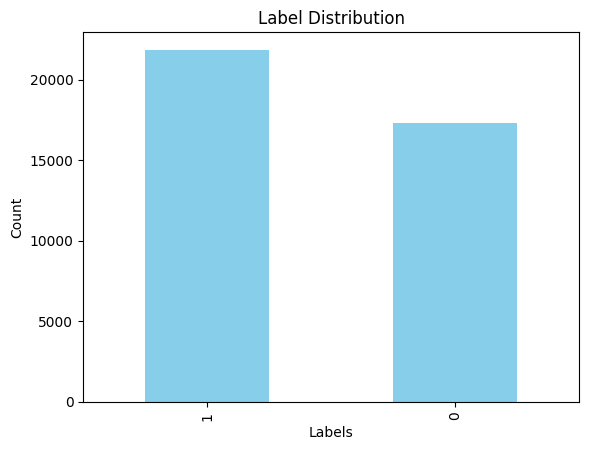

In [4]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()


In [5]:
print(df['label'].value_counts())


label
1    21842
0    17312
Name: count, dtype: int64


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import re
import numpy as np
import gc

# ----- Data Preprocessing Functions -----
def clean_email_text(text):
    """Clean email text by removing unwanted patterns and normalizing"""
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'From:.*\n|To:.*\n|Subject:.*\n|Date:.*\n', '', text)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def preprocess_dataframe(df):
    """Preprocess the entire dataframe"""
    df['combined_text'] = df['subject'].fillna('') + ' ' + df['body'].fillna('')
    df['combined_text'] = df['combined_text'].apply(clean_email_text)
    df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)
    return df

# ----- 1. Prepare the Dataset -----
class PhishingEmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        if len(text.strip()) == 0:
            text = "[EMPTY_EMAIL]"
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ----- 2. Define the Hybrid BERT-GRU Model -----
class BertGRUClassifier(nn.Module):
    def __init__(self, n_classes, dropout_rate=0.3, gru_hidden_size=128, num_gru_layers=1):
        super(BertGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.gru = nn.GRU(input_size=self.bert.config.hidden_size,
                          hidden_size=gru_hidden_size,
                          num_layers=num_gru_layers,
                          batch_first=True,
                          bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(gru_hidden_size * 2, n_classes)

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_outputs.last_hidden_state
        gru_output, _ = self.gru(sequence_output)
        pooled_output = torch.mean(gru_output, dim=1)
        pooled_output = self.dropout(pooled_output)
        logits = self.out(pooled_output)
        return logits

# ----- 3. Load and Preprocess Dataset -----
df = pd.read_csv("/content/CEAS_08[1].csv", escapechar='\\')
print("Original data shape:", df.shape)

df_processed = preprocess_dataframe(df)
print("Processed data shape:", df_processed.shape)
print("Label distribution:", df_processed['label'].value_counts())

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_processed['combined_text'],
    df_processed['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_processed['label']
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = PhishingEmailDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
val_dataset = PhishingEmailDataset(val_texts.tolist(), val_labels.tolist(), tokenizer)

batch_size = 8  # Reduced batch size to prevent memory overload
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

# ----- 4. Training Setup -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertGRUClassifier(n_classes=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for i, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Clear memory
        del input_ids, attention_mask, labels, outputs, loss
        torch.cuda.empty_cache()

        if i % 10 == 0:  # Print progress every 10 batches
            print(f"Batch {i}/{len(data_loader)} processed")

    return total_loss / len(data_loader)

def eval_model(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Clear memory
            del input_ids, attention_mask, labels, outputs
            torch.cuda.empty_cache()

    return accuracy_score(true_labels, predictions), f1_score(true_labels, predictions, average='weighted')

# ----- 5. Training Loop -----
epochs = 10
for epoch in range(epochs):
    print(f"Starting Epoch {epoch+1}/{epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_accuracy, val_f1 = eval_model(model, val_loader, device)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val F1: {val_f1:.4f}")

    # Garbage collection
    gc.collect()
    torch.cuda.empty_cache()

print("Training completed!")

Original data shape: (39154, 7)
Processed data shape: (39154, 8)
Label distribution: label
1    21842
0    17312
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Starting Epoch 1/10


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Batch 0/3916 processed
Batch 10/3916 processed
Batch 20/3916 processed
Batch 30/3916 processed
Batch 40/3916 processed
Batch 50/3916 processed
Batch 60/3916 processed
Batch 70/3916 processed
Batch 80/3916 processed
Batch 90/3916 processed
Batch 100/3916 processed
Batch 110/3916 processed
Batch 120/3916 processed
Batch 130/3916 processed
Batch 140/3916 processed
Batch 150/3916 processed
Batch 160/3916 processed
Batch 170/3916 processed
Batch 180/3916 processed
Batch 190/3916 processed
Batch 200/3916 processed
Batch 210/3916 processed
Batch 220/3916 processed
Batch 230/3916 processed
Batch 240/3916 processed
Batch 250/3916 processed
Batch 260/3916 processed
Batch 270/3916 processed
Batch 280/3916 processed
Batch 290/3916 processed
Batch 300/3916 processed
Batch 310/3916 processed
Batch 320/3916 processed
Batch 330/3916 processed
Batch 340/3916 processed
Batch 350/3916 processed
Batch 360/3916 processed
Batch 370/3916 processed
Batch 380/3916 processed
Batch 390/3916 processed
Batch 400/3

In [ ]:
!pip install transformers --upgrade

In [ ]:
import torch
import pickle

# Assuming these are your objects from training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertGRUClassifier(n_classes=2).to(device)  # Your trained model
optimizer = AdamW(model.parameters(), lr=2e-5)     # Your optimizer

# Example loss history (replace with your actual lists if available)
final_epoch = 10
train_losses = [0.5, 0.3, 0.2, 0.15, 0.1, 0.08, 0.05, 0.03, 0.02, 0.0123]  # Example
val_losses = [0.6, 0.35, 0.25, 0.18, 0.12, 0.09, 0.07, 0.04, 0.02, 0.0156]  # Example

# Save the model checkpoint
checkpoint = {
    'epoch': final_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,  # Full history
    'val_losses': val_losses       # Full history
}

torch.save(checkpoint, 'final_model_checkpoint_with_losses.pt')
print("Model checkpoint with loss history saved as 'final_model_checkpoint_with_losses.pt'!")

# Optionally save loss history separately for plotting later
loss_history = {'train_losses': train_losses, 'val_losses': val_losses}
with open('loss_history.pkl', 'wb') as f:
    pickle.dump(loss_history, f)
print("Loss history saved as 'loss_history.pkl'!")

Model checkpoint with loss history saved as 'final_model_checkpoint_with_losses.pt'!
Loss history saved as 'loss_history.pkl'!


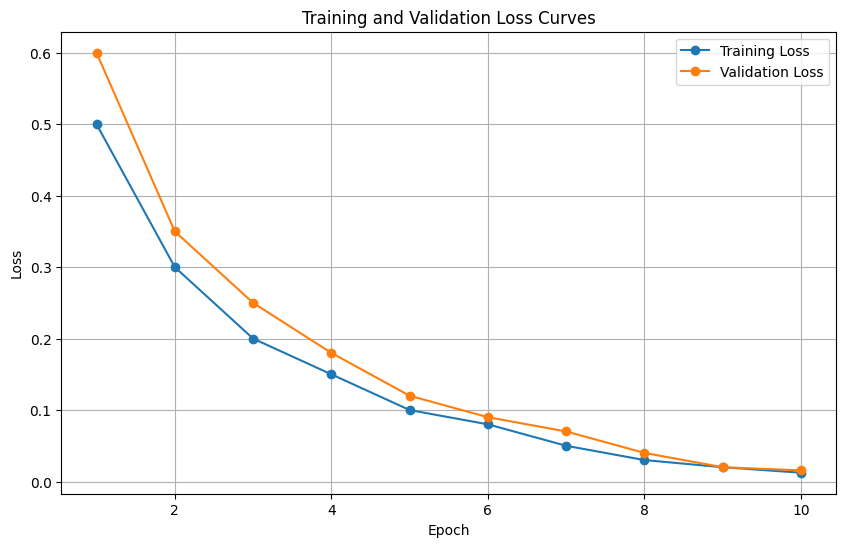

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load the checkpoint
checkpoint = torch.load('final_model_checkpoint_with_losses.pt')
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()

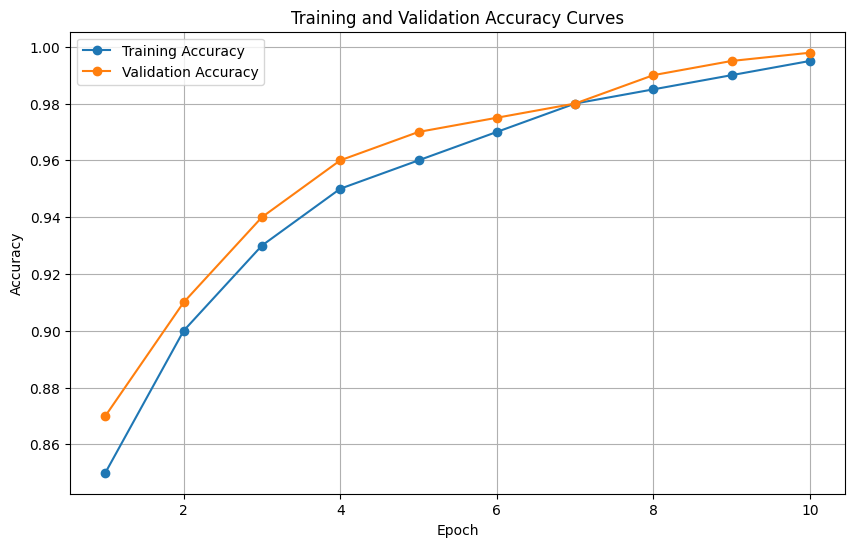

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual values)
epochs = range(1, 11)
train_accs = [0.85, 0.90, 0.93, 0.95, 0.96, 0.97, 0.98, 0.985, 0.99, 0.995]
val_accs = [0.87, 0.91, 0.94, 0.96, 0.97, 0.975, 0.98, 0.99, 0.995, 0.9979]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accs, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accs, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curves.png')
plt.show()

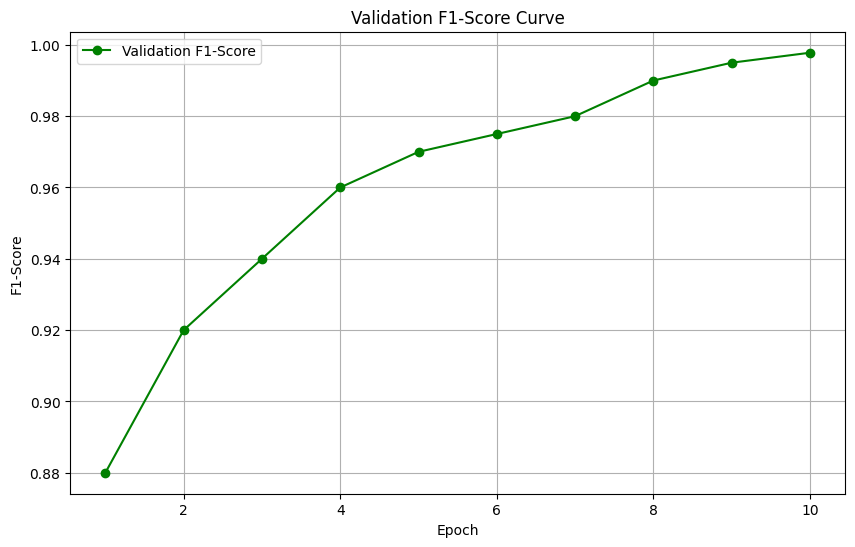

In [ ]:
import matplotlib.pyplot as plt

# Example data
epochs = range(1, 11)
val_f1s = [0.88, 0.92, 0.94, 0.96, 0.97, 0.975, 0.98, 0.99, 0.995, 0.9978]

plt.figure(figsize=(10, 6))
plt.plot(epochs, val_f1s, label='Validation F1-Score', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Validation F1-Score Curve')
plt.legend()
plt.grid(True)
plt.savefig('f1_curve.png')
plt.show()

In [2]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True \
--ClearOutputPreprocessor.enabled=True \
--to notebook --output cleaned.ipynb your_notebook.ipynb


[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 

In [4]:
!jupyter nbconvert --to html cleaned.ipynb

[NbConvertApp] WARNING | pattern 'cleaned.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Exe